### Part 01. Load packages and libs

In [1]:
import warnings
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

warnings.filterwarnings("ignore")

### Part 02. Writing a custom dataset for Blood Cell Segmemtation dataset, write data loader to load data for train model

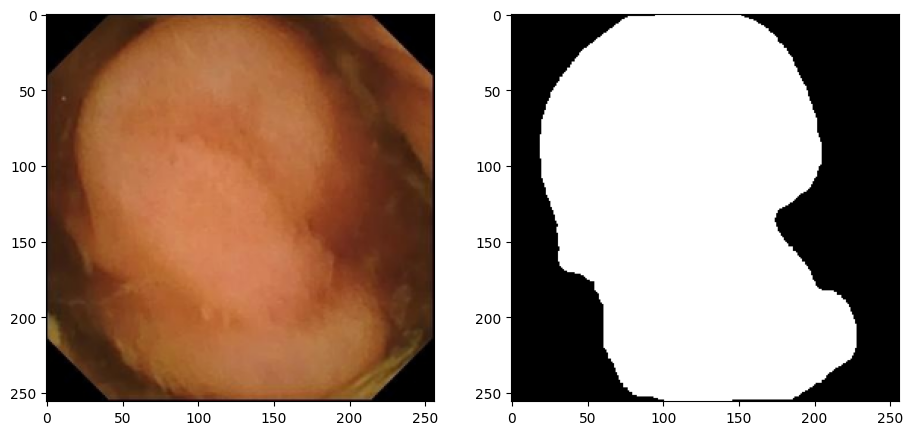

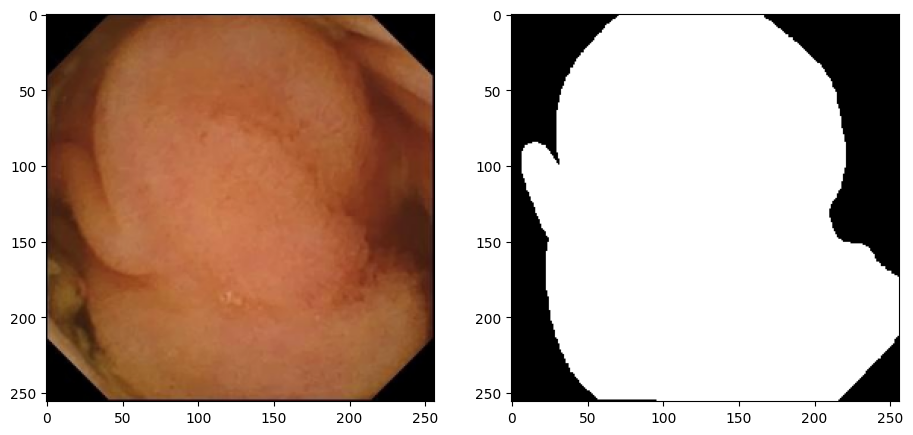

In [2]:
TRAIN_IMG_DIR = "datasets/kvasir_capsule/train/images"
TRAIN_MASK_DIR = "datasets/kvasir_capsule/train/masks"
VAL_IMG_DIR = "datasets/kvasir_capsule/test/images"
VAL_MASK_DIR = "datasets/kvasir_capsule/test/masks"


class BloodCellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None) -> None:
        super(BloodCellDataset, self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(
            self.mask_dir, self.images[index])

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),
                        dtype=np.float32)
        # mask[mask == 255.0] = 1.0
        mask = np.where(mask > 155.0, 1.0, 0.0)

        if self.transform is not None:
            augemantations = self.transform(image=image, mask=mask)
            image = augemantations['image']
            mask = augemantations['mask']
        return image, mask

def get_data_loaders(
        train_dir, train_mask_dir, val_dir, val_maskdir, batch_size,
        train_transform, val_transform):

    train_ds = BloodCellDataset(
        image_dir=train_dir, mask_dir=train_mask_dir,
        transform=train_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = BloodCellDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

BATCH_SIZE = 2
train_loader, val_loader = get_data_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms
)

def show_transformed(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch

    for img, mask in zip(images, labels):
        plt.figure(figsize=(11, 11))

        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))

        plt.subplot(1, 2, 2)
        # plt.imshow(mask.reshape(mask.shape[0], mask.shape[1], 1))
        plt.imshow(mask, cmap="gray")


show_transformed(val_loader)

### Part 03. Implement the deeplabv3+ model from scratch with pytorch

In [3]:
class ResNet_50(nn.Module):
    def __init__(self, output_layer=None):
        super(ResNet_50, self).__init__()
        self.pretrained = models.resnet50(pretrained=True)
        self.output_layer = output_layer

        self.layers = []
        for name, module in self.pretrained.named_children():
            self.layers.append((name, module))
            if name == self.output_layer:
                break

        self.net = nn.Sequential(*[module for _, module in self.layers])

    def forward(self, x):
        return self.net(x)

class Atrous_Convolution(nn.Module):
    def __init__(
            self, input_channels, kernel_size, pad, dilation_rate,
            output_channels=256):
        super(Atrous_Convolution, self).__init__()

        self.conv = nn.Conv2d(in_channels=input_channels,
                              out_channels=output_channels,
                              kernel_size=kernel_size, padding=pad,
                              dilation=dilation_rate, bias=False)

        self.batchnorm = nn.BatchNorm2d(output_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

class Atrous_Spatial_Pyramid_Pooling(nn.Module):
    def __init__(self, in_channles, out_channles):
        super(Atrous_Spatial_Pyramid_Pooling, self).__init__()
        self.conv_1x1 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=1, pad=0, dilation_rate=1)

        self.conv_3x3_r6 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=3, pad=6, dilation_rate=6)

        self.conv_3x3_r12 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=3, pad=12, dilation_rate=12)

        self.conv_3x3_r18 = Atrous_Convolution(
            input_channels=in_channles, output_channels=out_channles,
            kernel_size=3, pad=18, dilation_rate=18)

        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(
                in_channels=in_channles, out_channels=out_channles,
                kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.LayerNorm([out_channles, 1, 1]),
            # nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.final_conv = Atrous_Convolution(
            input_channels=out_channles * 5, output_channels=out_channles,
            kernel_size=1, pad=0, dilation_rate=1)

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3_r6 = self.conv_3x3_r6(x)
        x_3x3_r12 = self.conv_3x3_r12(x)
        x_3x3_r18 = self.conv_3x3_r18(x)
        img_pool_opt = self.image_pool(x)
        img_pool_opt = F.interpolate(
            img_pool_opt, size=x_3x3_r18.size()[2:],
            mode='bilinear', align_corners=True)
        concat = torch.cat(
            (x_1x1, x_3x3_r6, x_3x3_r12, x_3x3_r18, img_pool_opt),
            dim=1)
        x_final_conv = self.final_conv(concat)
        return x_final_conv

class Deeplabv3Plus(nn.Module):
    def __init__(self, num_classes):
        super(Deeplabv3Plus, self).__init__()
        self.backbone = ResNet_50(output_layer='layer3')
        self.low_level_features = ResNet_50(output_layer='layer1')

        self.aspp = Atrous_Spatial_Pyramid_Pooling(
            in_channles=1024, out_channles=256)

        self.conv1x1 = Atrous_Convolution(
            input_channels=256, output_channels=48, kernel_size=1,
            dilation_rate=1, pad=0)

        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.classifer = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        x_backbone = self.backbone(x)
        x_low_level = self.low_level_features(x)
        x_aspp = self.aspp(x_backbone)
        x_aspp_upsampled = F.interpolate(
            x_aspp, scale_factor=(4, 4),
            mode='bilinear', align_corners=True)
        x_conv1x1 = self.conv1x1(x_low_level)
        x_cat = torch.cat([x_conv1x1, x_aspp_upsampled], dim=1)
        x_3x3 = self.conv_3x3(x_cat)
        x_3x3_upscaled = F.interpolate(
            x_3x3, scale_factor=(4, 4),
            mode='bilinear', align_corners=True)
        x_out = self.classifer(x_3x3_upscaled)
        return x_out

### Part 04. Define the Dice loss func and IoU func because we are implementing from scratch

In [4]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_losss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        BCE = self.bce_losss(inputs, targets)
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(
            inputs.sum() + targets.sum() + smooth)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE


class IOU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)
        return IoU

### Part 05. Define some hyper-parameters and vars to prepare for train the model

In [5]:
model = Deeplabv3Plus(num_classes=1).to(DEVICE)
loss_fn = DiceBCELoss()

iou_fn = IOU()
scaler = torch.cuda.amp.GradScaler()
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_iou = []
train_dice = []
train_loss = []

def save_checkpoint(state, filename="model.pth.tar"):
    print("=> Saving checkpoint")
    # torch.save(state, filename)

In [6]:
model

Deeplabv3Plus(
  (backbone): ResNet_50(
    (pretrained): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): R

In [7]:
print(model)

Deeplabv3Plus(
  (backbone): ResNet_50(
    (pretrained): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): R

### Part 06. Start training model trained

In [8]:
start_time = time.time()

# let's train it just for 2 epochs
NUM_EPOCHS = 32

for epoch in range(NUM_EPOCHS):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}")

    iterations = 0
    iter_loss = 0.0
    iter_iou = 0.0

    batch_loop = tqdm(train_loader)
    for batch_idx, (data, targets) in enumerate(batch_loop):

        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.autocast(device_type=DEVICE, dtype=torch.bfloat16):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            iou = iou_fn(predictions, targets)

            iter_loss += loss.item()
            iter_iou += iou.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iterations += 1
        batch_loop.set_postfix(diceloss=loss.item(), iou=iou.item())

    train_loss.append(iter_loss / iterations)
    train_iou.append(iter_iou / iterations)
    # print(
    #     f"Epoch: {epoch+1}/{NUM_EPOCHS}, Training loss: {round(train_loss[-1] , 3)}")
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, IoU score: {iter_iou / iterations}")

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    # save_checkpoint(checkpoint)

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    # print(
    #     f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    # )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Total num_correct/num_pixels: {num_correct}/{num_pixels} => {num_correct/num_pixels}"
    )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Dice score: {dice_score / len(val_loader)}")
    train_dice.append(dice_score / len(val_loader))
    model.train()

print("done ..")

end_time = time.time()
training_time = end_time - start_time
print(
    f"The training time of the DeepLabv3+ model is: {training_time:.2f} seconds")

Epoch: 1/32


100%|██████████| 22/22 [00:04<00:00,  4.70it/s, diceloss=0.23, iou=0.859] 


Epoch: 1/32, IoU score: 0.744924699718302
Epoch: 1/32, Total num_correct/num_pixels: 564941/720896 => 0.7836650609970093
Epoch: 1/32, Dice score: 0.8376609426007825
Epoch: 2/32


100%|██████████| 22/22 [00:04<00:00,  5.27it/s, diceloss=0.124, iou=0.905]


Epoch: 2/32, IoU score: 0.8636599968780171
Epoch: 2/32, Total num_correct/num_pixels: 677951/720896 => 0.9404283165931702
Epoch: 2/32, Dice score: 0.9527818619209505
Epoch: 3/32


100%|██████████| 22/22 [00:04<00:00,  5.31it/s, diceloss=0.121, iou=0.901]


Epoch: 3/32, IoU score: 0.8917640935290944
Epoch: 3/32, Total num_correct/num_pixels: 685547/720896 => 0.9509652256965637
Epoch: 3/32, Dice score: 0.960728447202426
Epoch: 4/32


100%|██████████| 22/22 [00:04<00:00,  5.36it/s, diceloss=0.112, iou=0.92] 


Epoch: 4/32, IoU score: 0.9081723608753898
Epoch: 4/32, Total num_correct/num_pixels: 673975/720896 => 0.9349129796028137
Epoch: 4/32, Dice score: 0.9502197064769868
Epoch: 5/32


100%|██████████| 22/22 [00:04<00:00,  5.36it/s, diceloss=0.105, iou=0.925] 


Epoch: 5/32, IoU score: 0.9235100719061765
Epoch: 5/32, Total num_correct/num_pixels: 674162/720896 => 0.9351723790168762
Epoch: 5/32, Dice score: 0.9488625522214914
Epoch: 6/32


100%|██████████| 22/22 [00:04<00:00,  5.34it/s, diceloss=0.0686, iou=0.946]


Epoch: 6/32, IoU score: 0.9332157156684182
Epoch: 6/32, Total num_correct/num_pixels: 674878/720896 => 0.9361655712127686
Epoch: 6/32, Dice score: 0.9497826540201465
Epoch: 7/32


100%|██████████| 22/22 [00:04<00:00,  5.31it/s, diceloss=0.0752, iou=0.945]


Epoch: 7/32, IoU score: 0.9372752959078009
Epoch: 7/32, Total num_correct/num_pixels: 677830/720896 => 0.9402604699134827
Epoch: 7/32, Dice score: 0.953024460584101
Epoch: 8/32


100%|██████████| 22/22 [00:04<00:00,  5.21it/s, diceloss=0.0653, iou=0.951]


Epoch: 8/32, IoU score: 0.9414396367289803
Epoch: 8/32, Total num_correct/num_pixels: 675152/720896 => 0.9365456700325012
Epoch: 8/32, Dice score: 0.9508482548877929
Epoch: 9/32


100%|██████████| 22/22 [00:04<00:00,  5.21it/s, diceloss=0.0717, iou=0.948]


Epoch: 9/32, IoU score: 0.9514653818173842
Epoch: 9/32, Total num_correct/num_pixels: 676172/720896 => 0.9379605650901794
Epoch: 9/32, Dice score: 0.9518896589460432
Epoch: 10/32


100%|██████████| 22/22 [00:04<00:00,  5.22it/s, diceloss=0.0538, iou=0.959]


Epoch: 10/32, IoU score: 0.9553824663162231
Epoch: 10/32, Total num_correct/num_pixels: 672844/720896 => 0.9333440661430359
Epoch: 10/32, Dice score: 0.9483067748501154
Epoch: 11/32


100%|██████████| 22/22 [00:04<00:00,  4.94it/s, diceloss=0.0673, iou=0.954]


Epoch: 11/32, IoU score: 0.956409524787556
Epoch: 11/32, Total num_correct/num_pixels: 678394/720896 => 0.9410428404808044
Epoch: 11/32, Dice score: 0.9535509233381699
Epoch: 12/32


100%|██████████| 22/22 [00:04<00:00,  5.18it/s, diceloss=0.0458, iou=0.965]


Epoch: 12/32, IoU score: 0.9573008011687886
Epoch: 12/32, Total num_correct/num_pixels: 673710/720896 => 0.9345453977584839
Epoch: 12/32, Dice score: 0.9498665548447529
Epoch: 13/32


100%|██████████| 22/22 [00:04<00:00,  5.16it/s, diceloss=0.0468, iou=0.965]


Epoch: 13/32, IoU score: 0.9596901373429731
Epoch: 13/32, Total num_correct/num_pixels: 668092/720896 => 0.9267522692680359
Epoch: 13/32, Dice score: 0.944829715288779
Epoch: 14/32


100%|██████████| 22/22 [00:04<00:00,  5.20it/s, diceloss=0.04, iou=0.967]  


Epoch: 14/32, IoU score: 0.9615944623947144
Epoch: 14/32, Total num_correct/num_pixels: 682041/720896 => 0.9461018443107605
Epoch: 14/32, Dice score: 0.9584264736503766
Epoch: 15/32


100%|██████████| 22/22 [00:04<00:00,  5.17it/s, diceloss=0.0518, iou=0.963]


Epoch: 15/32, IoU score: 0.964310348033905
Epoch: 15/32, Total num_correct/num_pixels: 678479/720896 => 0.9411607384681702
Epoch: 15/32, Dice score: 0.9537832327799316
Epoch: 16/32


100%|██████████| 22/22 [00:04<00:00,  5.23it/s, diceloss=0.0432, iou=0.967]


Epoch: 16/32, IoU score: 0.9654136625203219
Epoch: 16/32, Total num_correct/num_pixels: 674943/720896 => 0.9362557530403137
Epoch: 16/32, Dice score: 0.9508816791209558
Epoch: 17/32


100%|██████████| 22/22 [00:04<00:00,  5.18it/s, diceloss=0.0422, iou=0.968]


Epoch: 17/32, IoU score: 0.9672680334611372
Epoch: 17/32, Total num_correct/num_pixels: 666951/720896 => 0.9251695275306702
Epoch: 17/32, Dice score: 0.9425301450237297
Epoch: 18/32


100%|██████████| 22/22 [00:04<00:00,  5.21it/s, diceloss=0.0619, iou=0.959]


Epoch: 18/32, IoU score: 0.9680470905520699
Epoch: 18/32, Total num_correct/num_pixels: 678149/720896 => 0.9407029747962952
Epoch: 18/32, Dice score: 0.9537516371451953
Epoch: 19/32


100%|██████████| 22/22 [00:04<00:00,  5.20it/s, diceloss=0.0342, iou=0.974]


Epoch: 19/32, IoU score: 0.9701046645641327
Epoch: 19/32, Total num_correct/num_pixels: 675158/720896 => 0.936553955078125
Epoch: 19/32, Dice score: 0.9510840302918334
Epoch: 20/32


100%|██████████| 22/22 [00:04<00:00,  5.03it/s, diceloss=0.0298, iou=0.976]


Epoch: 20/32, IoU score: 0.9710729420185089
Epoch: 20/32, Total num_correct/num_pixels: 671839/720896 => 0.9319499731063843
Epoch: 20/32, Dice score: 0.9482973552167713
Epoch: 21/32


100%|██████████| 22/22 [00:04<00:00,  5.10it/s, diceloss=0.0317, iou=0.977]


Epoch: 21/32, IoU score: 0.9722791341218081
Epoch: 21/32, Total num_correct/num_pixels: 668756/720896 => 0.92767333984375
Epoch: 21/32, Dice score: 0.9448217401345446
Epoch: 22/32


100%|██████████| 22/22 [00:04<00:00,  5.06it/s, diceloss=0.0273, iou=0.979]


Epoch: 22/32, IoU score: 0.9734351147304882
Epoch: 22/32, Total num_correct/num_pixels: 671727/720896 => 0.9317946434020996
Epoch: 22/32, Dice score: 0.947373700416418
Epoch: 23/32


100%|██████████| 22/22 [00:04<00:00,  5.02it/s, diceloss=0.0365, iou=0.975]


Epoch: 23/32, IoU score: 0.9754979827187278
Epoch: 23/32, Total num_correct/num_pixels: 674986/720896 => 0.9363154172897339
Epoch: 23/32, Dice score: 0.9507946874485009
Epoch: 24/32


100%|██████████| 22/22 [00:04<00:00,  4.95it/s, diceloss=0.0334, iou=0.977]


Epoch: 24/32, IoU score: 0.9745106534524397
Epoch: 24/32, Total num_correct/num_pixels: 670612/720896 => 0.930247962474823
Epoch: 24/32, Dice score: 0.9467898486368778
Epoch: 25/32


100%|██████████| 22/22 [00:04<00:00,  4.98it/s, diceloss=0.0349, iou=0.975]


Epoch: 25/32, IoU score: 0.9760957739569924
Epoch: 25/32, Total num_correct/num_pixels: 675312/720896 => 0.936767578125
Epoch: 25/32, Dice score: 0.951097243328797
Epoch: 26/32


100%|██████████| 22/22 [00:04<00:00,  5.05it/s, diceloss=0.0309, iou=0.978]


Epoch: 26/32, IoU score: 0.9755291153084148
Epoch: 26/32, Total num_correct/num_pixels: 673243/720896 => 0.9338975548744202
Epoch: 26/32, Dice score: 0.9491890266602941
Epoch: 27/32


100%|██████████| 22/22 [00:04<00:00,  5.05it/s, diceloss=0.0325, iou=0.978]


Epoch: 27/32, IoU score: 0.9772327867421237
Epoch: 27/32, Total num_correct/num_pixels: 676238/720896 => 0.9380521178245544
Epoch: 27/32, Dice score: 0.9522237910120981
Epoch: 28/32


100%|██████████| 22/22 [00:04<00:00,  5.02it/s, diceloss=0.0269, iou=0.98] 


Epoch: 28/32, IoU score: 0.9798241609876807
Epoch: 28/32, Total num_correct/num_pixels: 674953/720896 => 0.9362696409225464
Epoch: 28/32, Dice score: 0.9506377719418184
Epoch: 29/32


100%|██████████| 22/22 [00:04<00:00,  5.07it/s, diceloss=0.0288, iou=0.977]


Epoch: 29/32, IoU score: 0.9784769768064673
Epoch: 29/32, Total num_correct/num_pixels: 672470/720896 => 0.9328252673149109
Epoch: 29/32, Dice score: 0.9482843890620014
Epoch: 30/32


100%|██████████| 22/22 [00:04<00:00,  5.01it/s, diceloss=0.034, iou=0.977] 


Epoch: 30/32, IoU score: 0.9801064079458063
Epoch: 30/32, Total num_correct/num_pixels: 667692/720896 => 0.9261974096298218
Epoch: 30/32, Dice score: 0.9435823093723095
Epoch: 31/32


100%|██████████| 22/22 [00:04<00:00,  4.98it/s, diceloss=0.0245, iou=0.982]


Epoch: 31/32, IoU score: 0.9806236570531671
Epoch: 31/32, Total num_correct/num_pixels: 673862/720896 => 0.9347562193870544
Epoch: 31/32, Dice score: 0.9493845885700725
Epoch: 32/32


100%|██████████| 22/22 [00:04<00:00,  5.00it/s, diceloss=0.0222, iou=0.984]


Epoch: 32/32, IoU score: 0.9808619266206567
Epoch: 32/32, Total num_correct/num_pixels: 674397/720896 => 0.9354983568191528
Epoch: 32/32, Dice score: 0.9500531961528461
done ..
The training time of the DeepLabv3+ model is: 144.05 seconds


### Part 07. Visualize the training process and test the model trained

In [9]:
print(train_loss)

[0.4174420826814391, 0.20216407152739438, 0.14999909766695715, 0.1243008090691133, 0.10104755752465942, 0.08700489760799841, 0.08090932328592647, 0.07659612951630895, 0.06324588609012691, 0.05794881335036321, 0.05714006603441455, 0.055671830238266426, 0.052640497345816, 0.05069501494819468, 0.04705797051164237, 0.04514509422535246, 0.04315760799429633, 0.04185898618941957, 0.03879035171121359, 0.03839163431389765, 0.03647984538904645, 0.034624120220541954, 0.032327752306380055, 0.034149670211428944, 0.03326763796874068, 0.033444668843664906, 0.030476215295493603, 0.02662193656645038, 0.02807004978372292, 0.02618923969566822, 0.02526369064368985, 0.024828176268122414]


In [10]:
print(train_iou)

[0.744924699718302, 0.8636599968780171, 0.8917640935290944, 0.9081723608753898, 0.9235100719061765, 0.9332157156684182, 0.9372752959078009, 0.9414396367289803, 0.9514653818173842, 0.9553824663162231, 0.956409524787556, 0.9573008011687886, 0.9596901373429731, 0.9615944623947144, 0.964310348033905, 0.9654136625203219, 0.9672680334611372, 0.9680470905520699, 0.9701046645641327, 0.9710729420185089, 0.9722791341218081, 0.9734351147304882, 0.9754979827187278, 0.9745106534524397, 0.9760957739569924, 0.9755291153084148, 0.9772327867421237, 0.9798241609876807, 0.9784769768064673, 0.9801064079458063, 0.9806236570531671, 0.9808619266206567]


In [11]:
print(train_dice)

[tensor(0.8377, device='cuda:0', dtype=torch.float64), tensor(0.9528, device='cuda:0', dtype=torch.float64), tensor(0.9607, device='cuda:0', dtype=torch.float64), tensor(0.9502, device='cuda:0', dtype=torch.float64), tensor(0.9489, device='cuda:0', dtype=torch.float64), tensor(0.9498, device='cuda:0', dtype=torch.float64), tensor(0.9530, device='cuda:0', dtype=torch.float64), tensor(0.9508, device='cuda:0', dtype=torch.float64), tensor(0.9519, device='cuda:0', dtype=torch.float64), tensor(0.9483, device='cuda:0', dtype=torch.float64), tensor(0.9536, device='cuda:0', dtype=torch.float64), tensor(0.9499, device='cuda:0', dtype=torch.float64), tensor(0.9448, device='cuda:0', dtype=torch.float64), tensor(0.9584, device='cuda:0', dtype=torch.float64), tensor(0.9538, device='cuda:0', dtype=torch.float64), tensor(0.9509, device='cuda:0', dtype=torch.float64), tensor(0.9425, device='cuda:0', dtype=torch.float64), tensor(0.9538, device='cuda:0', dtype=torch.float64), tensor(0.9511, device='cuda

In [12]:
train_dice = [t.cpu().item() for t in train_dice]

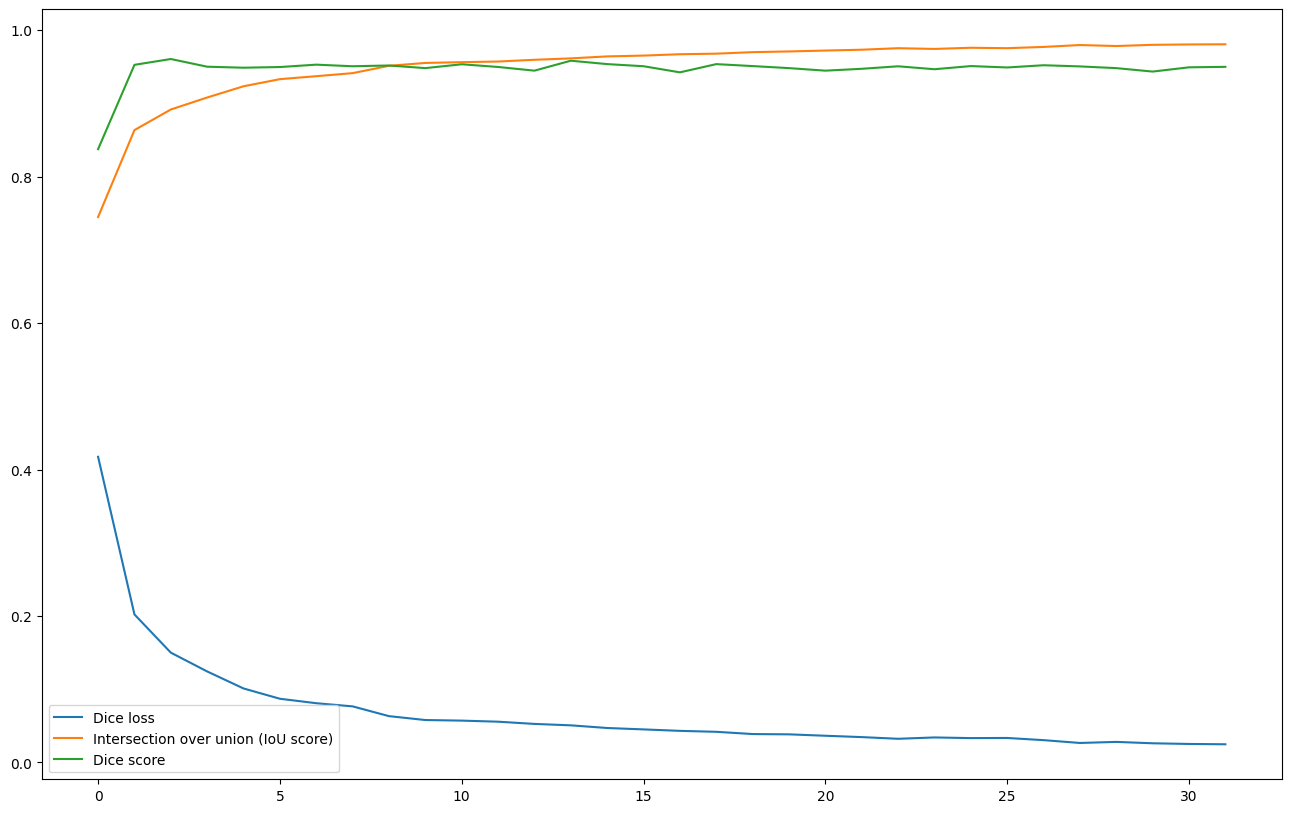

In [13]:
f = plt.figure(figsize=(16, 10))
plt.plot(train_loss, label='Dice loss')
plt.plot(train_iou, label='Intersection over union (IoU score)')
plt.plot(train_dice, label='Dice score')
plt.legend()
plt.show()

In [14]:
def test_model(model, val_loader, device):
    model.eval()
    dice_score = 0
    iou_metric = IOU()
    iou_score = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Testing"):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            dice_score += (2 * (preds_binary * y).sum()) / (
                (preds_binary + y).sum() + 1e-8
            )
            iou_score += iou_metric(preds_binary, y)

    avg_dice = dice_score / len(val_loader)
    avg_iou = iou_score / len(val_loader)

    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")

    return avg_dice, avg_iou


avg_dice, avg_iou = test_model(model, val_loader, DEVICE)

Testing: 100%|██████████| 6/6 [00:00<00:00, 33.29it/s]

Average Dice Score: 0.9501
Average IoU Score: 0.5238


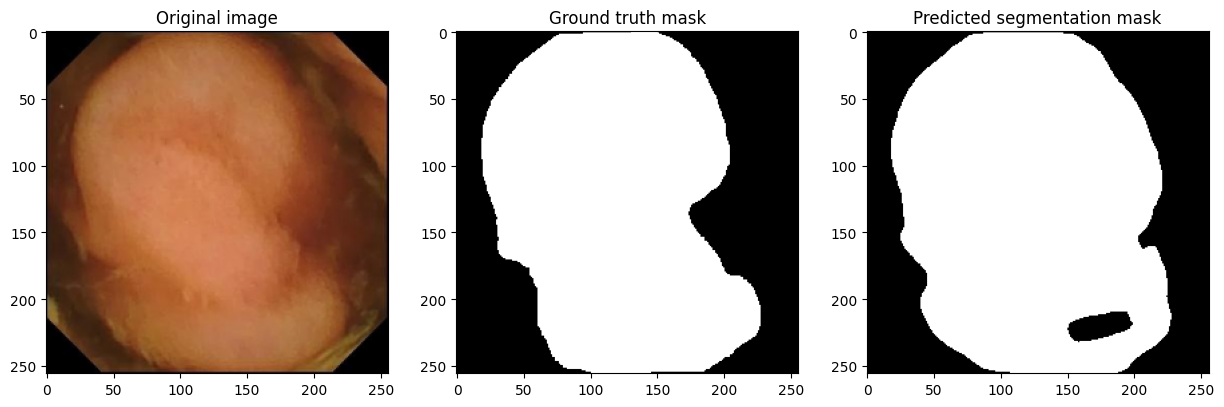

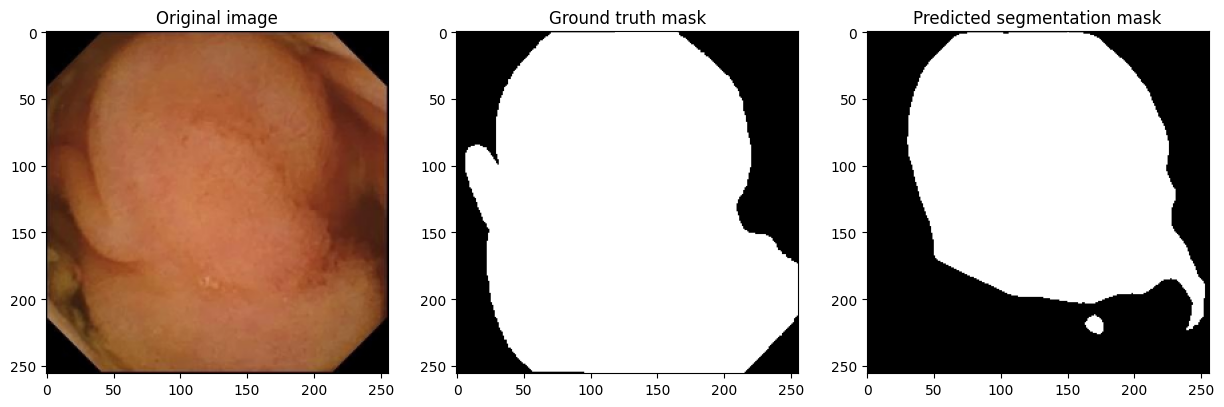

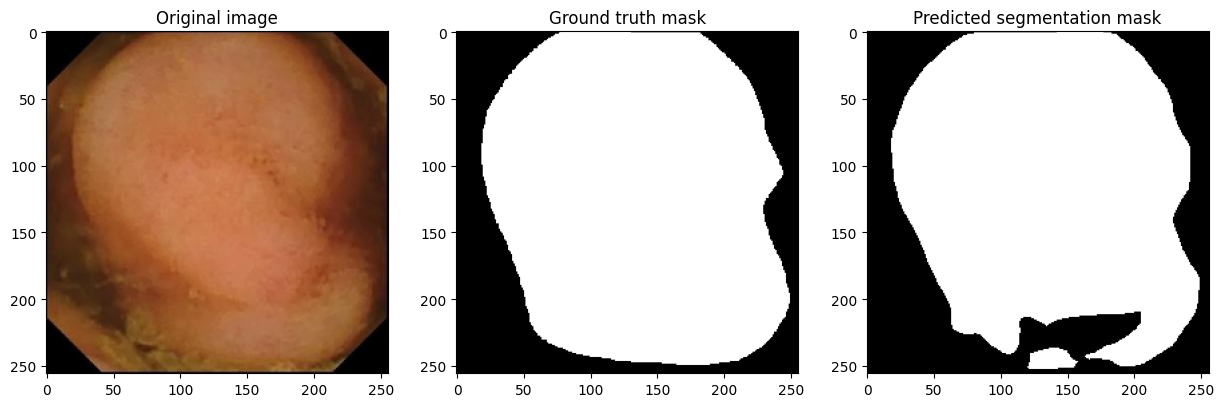

In [15]:
def visualize_predictions(model, val_loader, device, num_samples=3):
    model.eval()
    samples = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            for i in range(x.size(0)):
                if samples >= num_samples:
                    break

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.title("Original image")
                plt.imshow(np.transpose(x[i].cpu().numpy(), (1, 2, 0)))

                plt.subplot(1, 3, 2)
                plt.title("Ground truth mask")
                plt.imshow(y[i].cpu().numpy().squeeze(), cmap="gray")

                plt.subplot(1, 3, 3)
                plt.title("Predicted segmentation mask")
                plt.imshow(preds_binary[i].cpu(
                ).numpy().squeeze(), cmap="gray")

                plt.show()
                samples += 1

            if samples >= num_samples:
                break

visualize_predictions(model, val_loader, DEVICE)

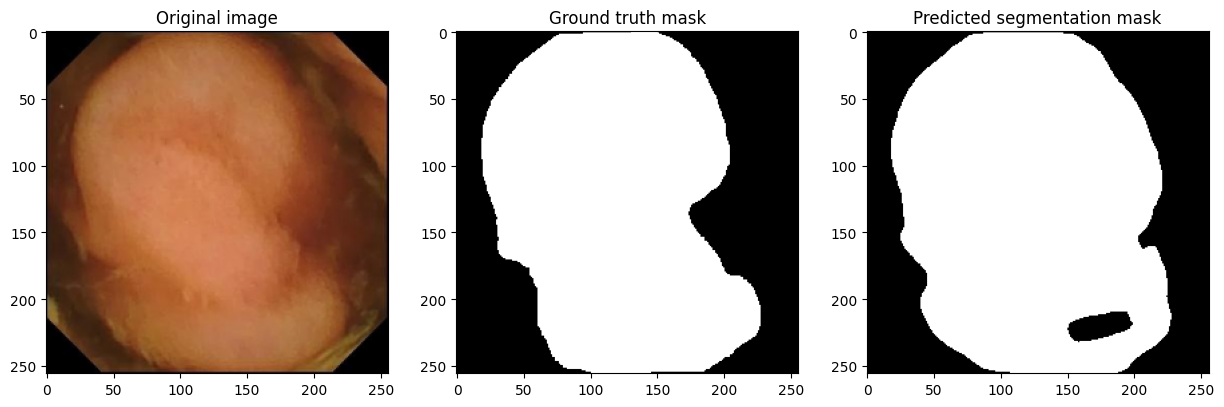

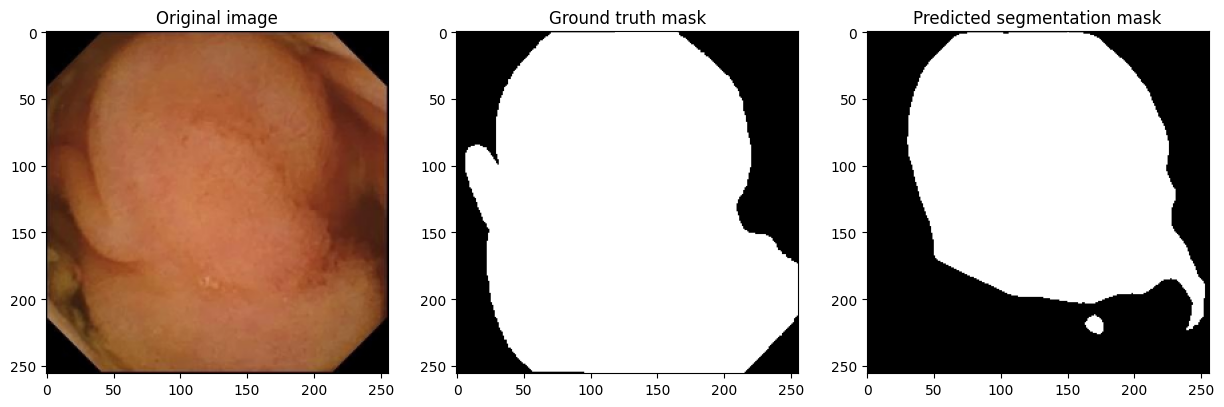

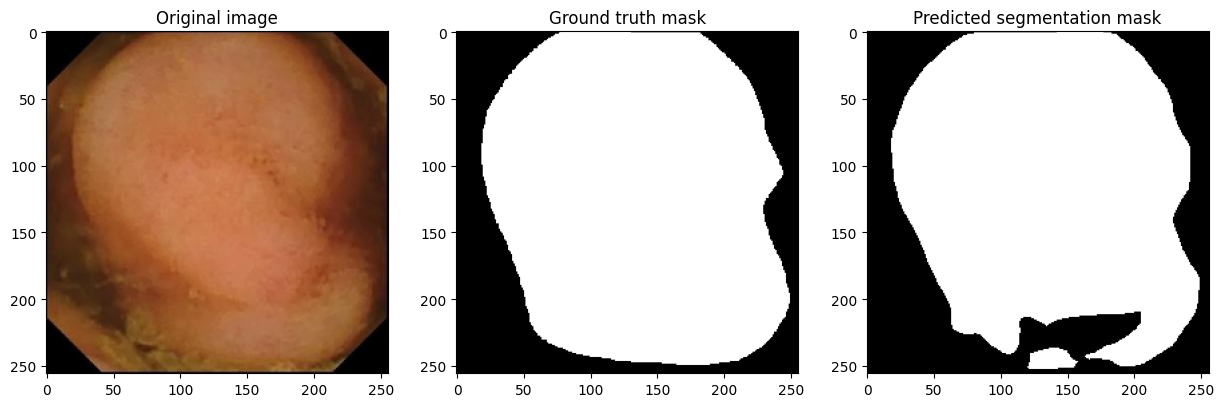

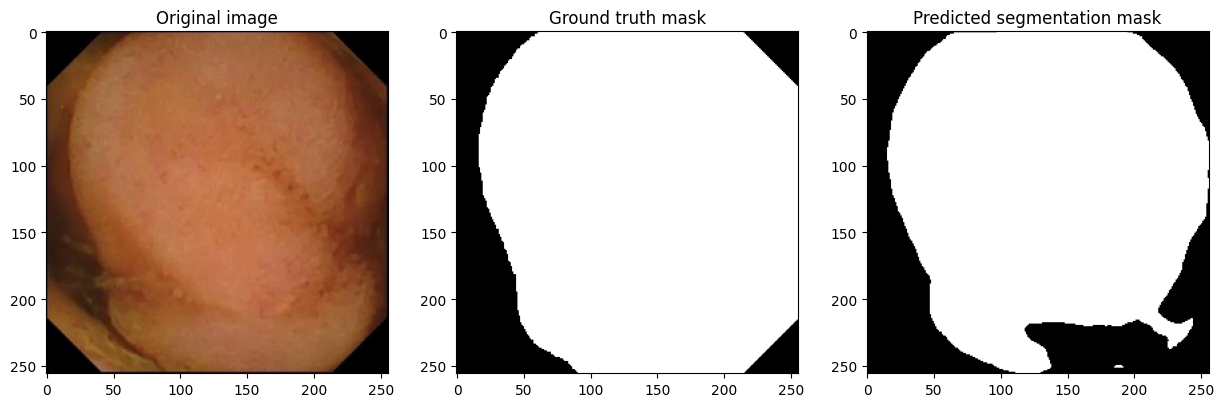

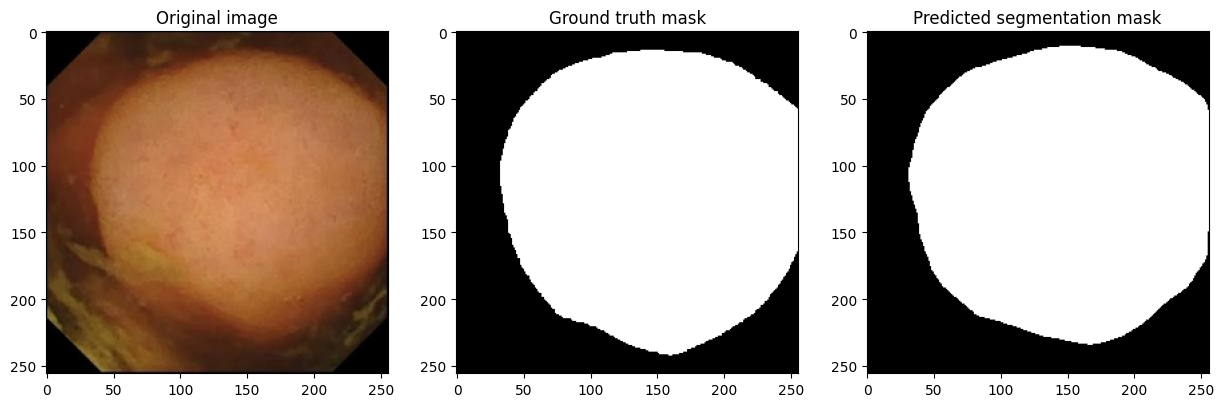

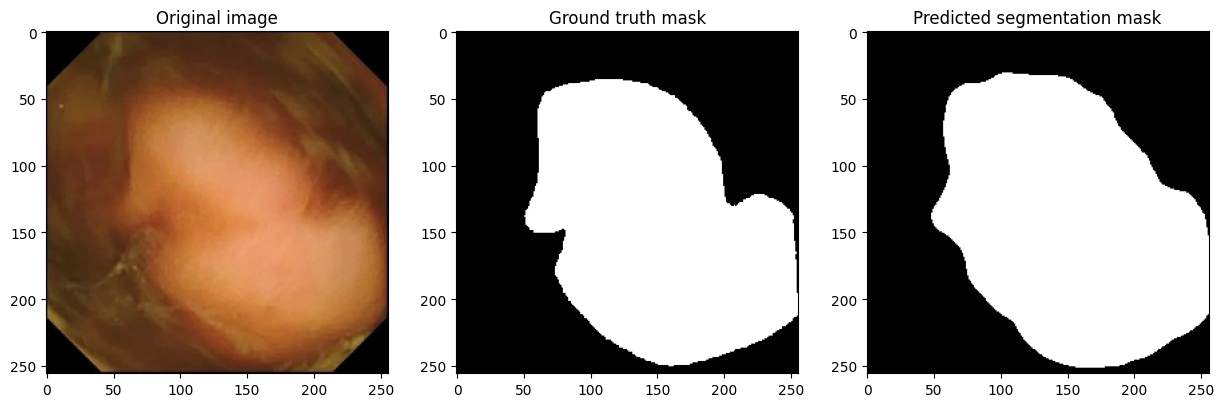

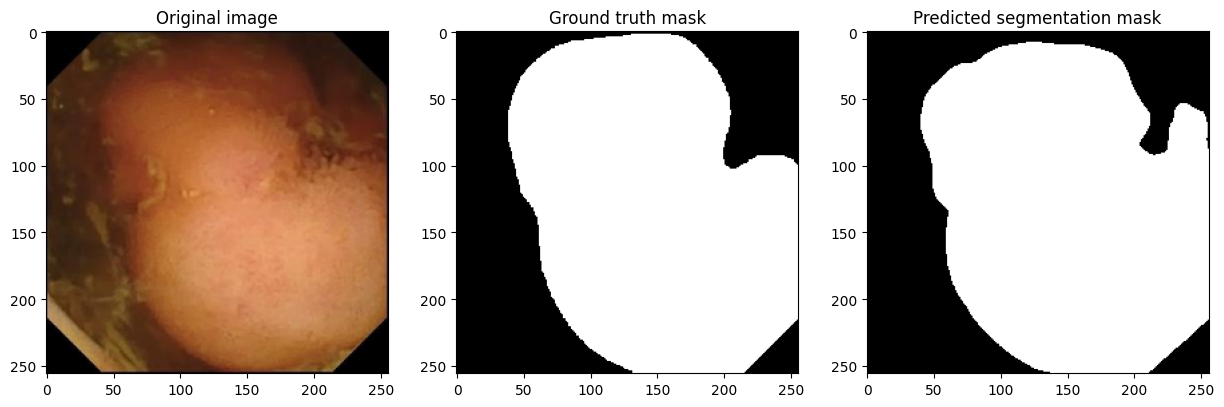

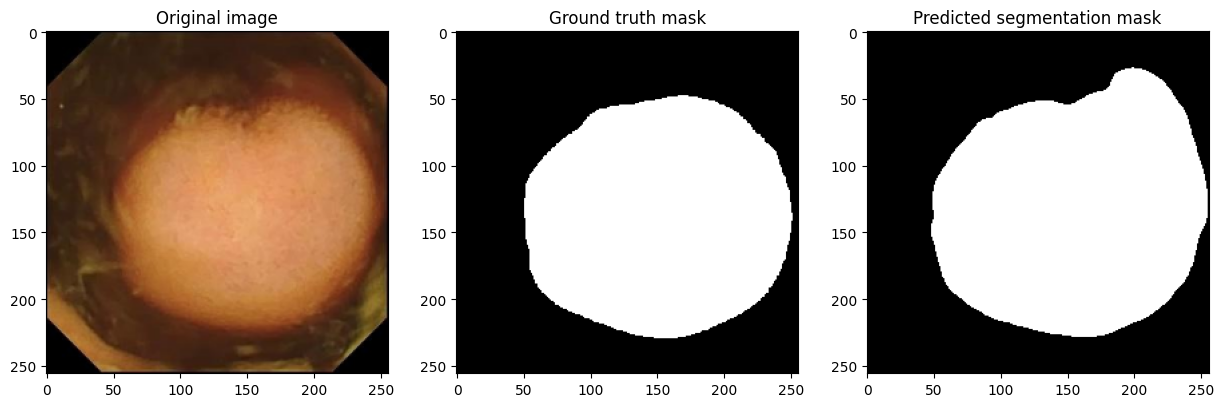

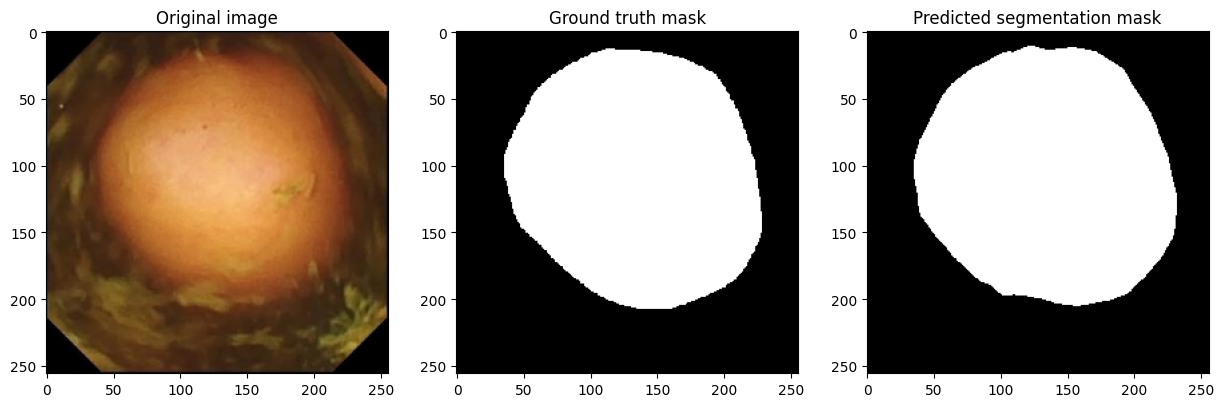

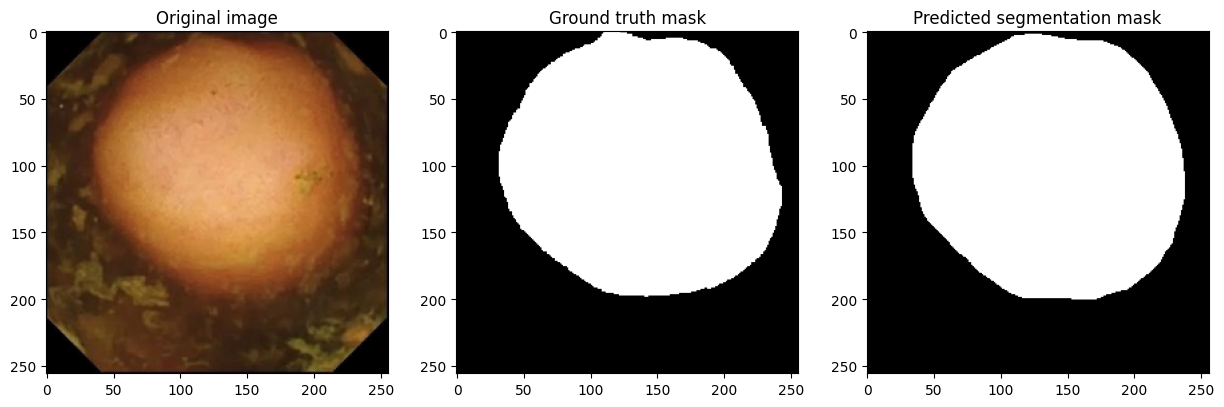

In [16]:
visualize_predictions(model, val_loader, DEVICE, num_samples=10)

In [17]:
# visualize_predictions(model, val_loader, DEVICE, num_samples=50)

In [18]:
# visualize_predictions(model, val_loader, DEVICE, num_samples=100)